# Importing Libraries

In [116]:
from     alpha_vantage.foreignexchange import ForeignExchange
from     alpha_vantage.timeseries import TimeSeries
from     collections import Counter
from     matplotlib.pyplot import figure
import   matplotlib.pyplot as plt
import   numpy as np
import   pandas as pd
import   pandas_ta
import   plotly.graph_objs as go
import   plotly.offline as pox
from     sklearn.base import clone 
from     sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from     sklearn.ensemble import VotingClassifier
from     sklearn.linear_model import LogisticRegression
from     sklearn.metrics import accuracy_score, classification_report, f1_score, roc_auc_score
from     sklearn.model_selection import train_test_split
from     sklearn.naive_bayes import GaussianNB
from     sklearn.neighbors import KNeighborsClassifier
from     sklearn.preprocessing import LabelEncoder, StandardScaler
from     sklearn.svm import SVC
from     sklearn.tree import DecisionTreeClassifier
from     sklearn.utils import resample
import   seaborn as sns
from     statsmodels.tsa.stattools import adfuller
from     statistics import mode
import   talib as ta
from     xgboost import XGBClassifier
import   yfinance as yf


from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten

In [117]:
import warnings
warnings.filterwarnings('ignore')

# Importing Stock Data

In [118]:
df = pd.read_csv(r'C:\Users\Daniel aghanya\Pictures\tiktok download\Final_Year_Project-main\Uni project\Project\aghanyan_Dissertation_Project_Files\Data\NSECleaned.csv')
# df.drop(df.tail(16).index,inplace=True)
next=df.copy()
next.tail()

,Date,Price,open,high,low,volume,Change %,close
1646,2023-12-18,72404.91,72389.23,72413.13,72276.75,324150000.0,0.0002,72404.91
1647,2023-12-19,72470.10,72404.91,72489.21,72320.32,411060000.0,0.0009,72470.10
1648,2023-12-20,73397.71,72470.10,73399.61,72470.10,552220000.0,0.0128,73397.71
1649,2023-12-21,74289.02,73397.71,74292.76,73397.71,760930000.0,0.0121,74289.02
1650,2023-12-22,74023.27,74288.88,74430.47,73993.49,423200000.0,-0.0036,74023.27


In [119]:
tfig = go.Figure()
tfig.add_trace(go.Candlestick(
    x=df.index, 
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    name='market data'
))

tfig.update_layout(
    title='NSE live share price evolution',
    yaxis_title='Stock Price (in $)'
)

tfig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=15, label='15m', step='minute', stepmode='backward'),
            dict(count=45, label='45m', step='minute', stepmode='backward'),
            dict(count=1, label='HTD', step='hour', stepmode='todate'),
            dict(count=2, label='2h', step='hour', stepmode='backward'),
            dict(step='all')
        ])
    )
)

tfig.show()


# Feature Engineering

In [120]:
df['future_returns'] = df['close'].pct_change().shift(-1)
signal=[]
for i in range(len(df)):
    if (df['future_returns'][i]  > 0):
        signal.append(1)
    elif (df['future_returns'][i] < 0):
        signal.append(2)
    else:
        signal.append(3)


df['signal']=signal
#df['rsi'] = ta.RSI(df['close'].values, timeperiod=int(14))
df['adx'] = ta.ADX(df['high'].values, df['low'].values,df['open'].values, timeperiod=int(50))
df['NATR'] = ta.NATR(df['high'], df['low'], df["close"], timeperiod=50)
df['pct_change_5'] = df['close'].pct_change(5)
df['pct_change'] = df['close'].pct_change()
df['sma'] = ta.SMA(df['close'],timeperiod=30)
df['corr'] = df['close'].rolling(window=int(6.5*4)).corr(df['sma'])
df['Open-Close']=(df["open"]-df['close']).shift(-1)
df['Close-High']=(df["close"]-df['high']).shift(-1)
df['Close-Low']=(df["close"]-df['low']).shift(-1)
#df['macd'], df['macdsignal'], df['macdhist'] = ta.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)
df['upper_band'], df['middle_band'], df['lower_band'] = ta.BBANDS(df['close'], timeperiod=20)


## Calculate the log high/low and log close/open
#log_hl = np.log(df['high'] / df['low']) ** 2
#log_co = np.log(df['close'] / df['open']) ** 2
#
##Adding some Additional Feature engineeering techniques
## Rolling Windows
#df['rolling_mean'] = df['close'].rolling(window=20).mean()
#df['rolling_std'] = df['close'].rolling(window=20).std()
#df['ema50'] = df['close'].ewm(span=50, adjust=False).mean()
#
## Statistical Features
#df['rate_of_change'] = df['close'].pct_change().fillna(0)
#df['z_score'] = (df['close'] - df['rolling_mean']) / df['rolling_std']
#
## Feature Interaction
#df['close_volume_interaction'] = df['close'] * df['volume']


## Technical Indicators
#df['momentum'] = df['close'] - df['close'].shift(4)
#df['slowk'], df['slowd'] = ta.STOCH(df['high'], df['low'], df['close'], fastk_period=5, slowk_period=3, slowd_period=3)

df

,Date,Price,open,high,low,volume,Change %,close,future_returns,signal,...,pct_change_5,pct_change,sma,corr,Open-Close,Close-High,Close-Low,upper_band,middle_band,lower_band
0,2015-09-23,30543.17,30426.78,30560.93,30425.31,466940000.0,0.0038,30543.17,-0.099860,2,...,NaN,NaN,NaN,NaN,-124.71,-24.01,128.94,NaN,NaN,NaN
1,2016-08-30,27493.12,27368.41,27517.13,27364.18,230130000.0,0.0046,27493.12,0.003852,1,...,NaN,-0.099860,NaN,NaN,-105.91,-13.10,111.83,NaN,NaN,NaN
2,2016-08-31,27599.03,27493.12,27612.13,27487.20,262610000.0,0.0039,27599.03,0.029743,1,...,NaN,0.003852,NaN,NaN,-820.89,-1.35,820.89,NaN,NaN,NaN
3,2016-09-01,28419.92,27599.03,28421.27,27599.03,229230000.0,0.0297,28419.92,-0.023338,2,...,NaN,0.029743,NaN,NaN,663.25,-731.33,11.91,NaN,NaN,NaN
4,2016-09-02,27756.67,28419.92,28488.00,27744.76,309450000.0,-0.0233,27756.67,-0.001785,2,...,NaN,-0.023338,NaN,NaN,49.55,-79.63,27.70,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1646,2023-12-18,72404.91,72389.23,72413.13,72276.75,324150000.0,0.0002,72404.91,0.000900,1,...,0.010255,0.000217,71322.019667,0.864426,-65.19,-19.11,149.78,72526.218268,71547.4710,70568.723732
1647,2023-12-19,72470.10,72404.91,72489.21,72320.32,411060000.0,0.0009,72470.10,0.012800,1,...,0.007827,0.000900,71383.903000,0.860499,-927.61,-1.90,927.61,72648.298073,71617.6485,70586.998927
1648,2023-12-20,73397.71,72470.10,73399.61,72470.10,552220000.0,0.0128,73397.71,0.012144,1,...,0.015186,0.012800,71471.380667,0.831631,-891.31,-3.74,891.31,72987.672991,71737.3350,70486.997009
1649,2023-12-21,74289.02,73397.71,74292.76,73397.71,760930000.0,0.0121,74289.02,-0.003577,2,...,0.025301,0.012144,71587.028667,0.797475,265.61,-407.20,29.78,73532.279273,71899.1435,70266.007727


In [121]:

df.dropna(inplace=True)

y = df[['signal']].copy()
print(y)
exclude_columns = ['Date', 'signal','NATR','adj close','close','future_returns','high','low','macdhist', 
                   'macdsignal','open','pct_change_5','pct_change','sma']   # Add any other columns you want to exclude from X
X = df[df.columns.difference(exclude_columns)]
print(X)

      signal
99         1
100        1
101        1
102        2
103        2
...      ...
1645       1
1646       1
1647       1
1648       1
1649       2

[1551 rows x 1 columns]
      Change %  Close-High  Close-Low  Open-Close     Price        adx  \
99     -0.0005       -7.91      25.60      -22.91  26217.54  25.121344   
100     0.0009       -5.34      78.70      -49.50  26240.45  24.888559   
101     0.0019      -33.23      51.14      -38.27  26289.95  24.642240   
102     0.0015     -122.17      26.05      111.04  26328.22  24.375187   
103    -0.0042     -208.56     124.02      180.94  26217.18  24.139882   
...        ...         ...        ...         ...       ...        ...   
1645   -0.0009       -8.22     128.16      -15.68  72389.23  31.166705   
1646    0.0002      -19.11     149.78      -65.19  72404.91  31.243861   
1647    0.0009       -1.90     927.61     -927.61  72470.10  31.327508   
1648    0.0128       -3.74     891.31     -891.31  73397.71  31.500122   
1649 

# Correlation Check

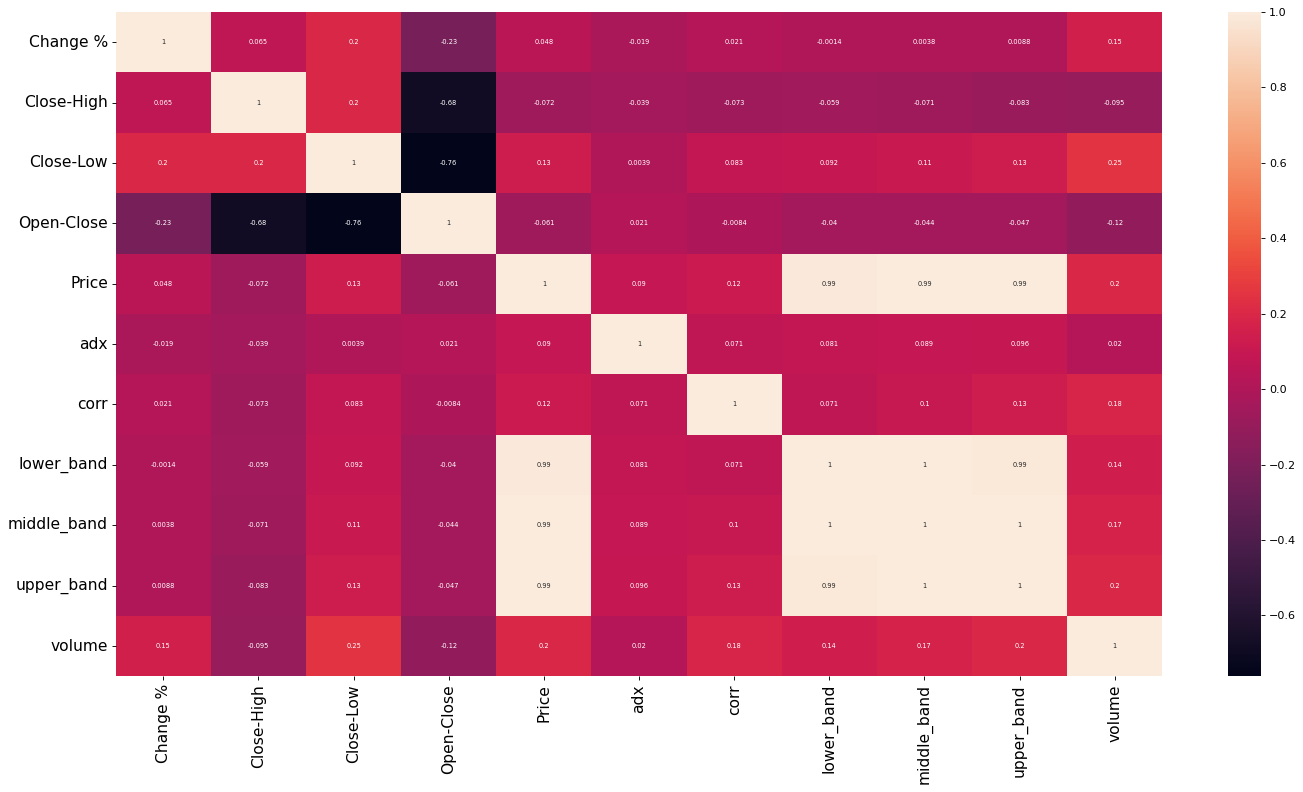

In [122]:
exclude_columns = ['Date', 'signal','NATR','adj close','close','future_returns','high','low','macdhist', 
                   'macdsignal','open','pct_change_5','pct_change','sma'] 
z=df[df.columns.difference(exclude_columns)].copy()
corr = z.corr()
figure(figsize=(18, 10), dpi=80)
sns.heatmap(corr, annot=True, annot_kws = {"size": 6})
plt.yticks(rotation=0, size = 14); 
plt.xticks(rotation=90, size = 14)  # fix ticklabel directions and size
plt.tight_layout()  # fits plot area to the plot, "tightly"
plt.show()  # show the plot

In [123]:
def get_pair_above_threshold(X, threshold):
    """Function to return the pairs with correlation above threshold.
    """
    # Calculate the correlation matrix
    correl = X.corr()

    # Unstack the matrix
    correl = correl.abs().unstack()

    # Recurring & redundant pair
    pairs_to_drop = set()
    cols = X.corr().columns
   
    for i in range(0, X.corr().shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))

    # Drop the recurring & redundant pair
    correl = correl.drop(labels=pairs_to_drop).sort_values(ascending=False)

    return correl[correl > threshold].index


print(get_pair_above_threshold(X, 0.7))


MultiIndex([('middle_band',  'upper_band'),
            ( 'lower_band', 'middle_band'),
            (      'Price',  'upper_band'),
            (      'Price', 'middle_band'),
            (      'Price',  'lower_band'),
            ( 'lower_band',  'upper_band'),
            (  'Close-Low',  'Open-Close')],
           )


# Stationary Check

In [124]:
def stationary(series):
    """Function to check if the series is stationary or not.
    """
    result = adfuller(series)
    if(result[1] < 0.05):
        return 'stationary'
    else:
        return 'not stationary'
# Check for stationarity
for col in X.columns:
    if stationary(df[col]) == 'not stationary':
        print('%s is not stationary. Dropping it.' % col)
        X.drop(columns=[col], axis=1, inplace=True)
    else:
        print('%s is stationary.' % col)
        


Change % is stationary.
Close-High is stationary.
Close-Low is stationary.
Open-Close is stationary.
Price is not stationary. Dropping it.
adx is stationary.
corr is stationary.
lower_band is not stationary. Dropping it.
middle_band is not stationary. Dropping it.
upper_band is not stationary. Dropping it.
volume is stationary.


# Splitting and Training Model

In [125]:
print(X)
print(y)

      Change %  Close-High  Close-Low  Open-Close        adx      corr  \
99     -0.0005       -7.91      25.60      -22.91  25.121344 -0.744335   
100     0.0009       -5.34      78.70      -49.50  24.888559 -0.749888   
101     0.0019      -33.23      51.14      -38.27  24.642240 -0.732519   
102     0.0015     -122.17      26.05      111.04  24.375187 -0.710462   
103    -0.0042     -208.56     124.02      180.94  24.139882 -0.716509   
...        ...         ...        ...         ...        ...       ...   
1645   -0.0009       -8.22     128.16      -15.68  31.166705  0.854633   
1646    0.0002      -19.11     149.78      -65.19  31.243861  0.864426   
1647    0.0009       -1.90     927.61     -927.61  31.327508  0.860499   
1648    0.0128       -3.74     891.31     -891.31  31.500122  0.831631   
1649    0.0121     -407.20      29.78      265.61  31.748116  0.797475   

           volume  
99    187700000.0  
100   189990000.0  
101   146490000.0  
102   237790000.0  
103   14352

In [126]:
split_percentage = 0.8
split = int(split_percentage*len(df))

# Train data set
X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]

In [127]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1240, 7)
(1240, 1)
(311, 7)
(311, 1)


In [128]:
# use transform instead of fit_transform for testing data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [129]:


# Define each model with the specified parameters
#model = SVC(C=1, kernel='rbf', degree=3, probability=True)
#model1 = LogisticRegression(max_iter=1000)  # Assuming '1bfgs' was a typo and should be 'lbfgs'
#model3 = DecisionTreeClassifier(criterion='gini', random_state=20, min_samples_split=2)  # Random state and min_samples_split set based on one of the provided values
model = RandomForestClassifier(n_estimators=100, criterion='gini', random_state=30, min_samples_leaf=4, min_samples_split=2)
#model=AdaBoostClassifier(n_estimators=100, algorithm='SAMME.R', learning_rate=1, estimator=model3)
#model = KNeighborsClassifier(n_neighbors=5)

#model = VotingClassifier([('lr', model1), ('ds', model2), ('svm', model3),('ada', model4)], voting='soft')

#encoder = LabelEncoder()
#y_train['signal'] = encoder.fit_transform(y_train['signal'])
#y_test = encoder.transform(y_test)
#model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, use_label_encoder=False, eval_metric='mlogloss')

print(model)

model.fit(X_train, y_train['signal'])
y_pred = model.predict(X_test)

Accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {Accuracy:.4f}")

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-Score: {f1:.4f}")

RandomForestClassifier(min_samples_leaf=4, random_state=30)
Accuracy: 0.9936
F1-Score: 0.9936


# Confusion Matrix

In [130]:
# Classification report
classification_report_data = classification_report(y_test, y_pred)
# Print the classification report
print(classification_report_data)

              precision    recall  f1-score   support

           1       0.99      0.99      0.99       190
           2       0.99      0.99      0.99       121

    accuracy                           0.99       311
   macro avg       0.99      0.99      0.99       311
weighted avg       0.99      0.99      0.99       311



# Bootstrapping 

In [131]:
# Bootstrapping function for training multiple models
def bootstrap_training(X_train, y_train, model, n_bootstrap=1000):
    models = []
    for _ in range(n_bootstrap):
        # Resampling with replacement
        X_resampled, y_resampled = resample(X_train, y_train)
        # Clone the model to ensure each bootstrap sample gets a fresh model
        cloned_model = clone(model)
        cloned_model.fit(X_resampled, y_resampled)
        models.append(cloned_model)
    return models

In [132]:
# Function to predict with an ensemble of models
def predict_with_ensemble(models, X):
    # Get predictions from all models (for majority voting, we're interested in the class labels, not probabilities)
    all_predictions = np.array([model.predict(X) for model in models])
    # Aggregate predictions by majority voting
    aggregated_predictions = np.apply_along_axis(lambda x: mode(x), arr=all_predictions, axis=0)
    return aggregated_predictions

In [133]:
# Implement bootstrapping in the existing workflow using the model choosen above
ensemble_models = bootstrap_training(X_train, y_train, model, n_bootstrap=10)

# Modify the prediction mechanism to use the ensemble
y_pred = predict_with_ensemble(ensemble_models, X_test)


# calculate Performance
Accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {Accuracy:.4f}")

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-Score: {f1:.4f}")


Accuracy: 0.9904
F1-Score: 0.9904


In [134]:
X_np = X.values
X_np = X_np.reshape(X_np.shape[0], X_np.shape[1], 1)

# confusion Matrix

In [137]:
# Classification report
classification_report_data = classification_report(y_test, y_pred)
# Print the classification report
print(classification_report_data)

              precision    recall  f1-score   support

           1       0.61      1.00      0.76       190
           2       0.00      0.00      0.00       121

    accuracy                           0.61       311
   macro avg       0.31      0.50      0.38       311
weighted avg       0.37      0.61      0.46       311



# Making Latest Prediciton

In [138]:
Prediction=model.predict(X.values)[-1]
if Prediction==1:
    print('Buy')
elif Prediction==2:
    print('Sell')
else:
    print('Hold')
print(Prediction)

49/49 [==============================] - 0s 5ms/step
Buy
[1.]


In [139]:
split_percentage = 0.8
split = int(split_percentage*len(df))
temp=pd.DataFrame()
temp['close'] = df.close.iloc[split:]
temp['signal']=np.array(y_pred)
temp.tail()

,close,signal
1645,72389.23,1
1646,72404.91,1
1647,72470.10,1
1648,73397.71,1
1649,74289.02,1


In [140]:
# Variable Required for decision making
buy=[]
sell=[]
profit=[]
Close_profit=[]
Stop_loss=[]
Close_order_buy=[]
Close_order_sell=[]
position_Buy=None
position_Sell=None
profit=0.4
lose=0.4

# Decision Making Process

In [141]:
for i in range(len(temp)):
   #####################################################################################################
    if position_Buy!="Buy"  and position_Sell!="Sell" and Accuracy >0.50 and temp['signal'].iloc[i]== 1 :                          #Buy Position
                    buy.append(temp['close'].iloc[i])
                    sell.append(np.nan)
                    Close_profit.append(np.nan)
                    Stop_loss.append(np.nan)
                    Close_order_buy.append(temp['close'].iloc[i])
                    position_Buy="Buy"
    #############################################################################################
    elif  position_Sell!="Sell"  and position_Buy!="Buy" and Accuracy >0.50 and temp['signal'].iloc[i]== 2   :                     #Sell Position        
                sell.append(temp['close'].iloc[i])              
                buy.append(np.nan)
                Close_profit.append(np.nan)
                Stop_loss.append(np.nan)
                Close_order_sell.append(temp['close'].iloc[i])
                position_Sell="Sell"
        
    #################################################################################################
    elif position_Sell=="Sell" :                                               #Closing Order  After  Buying a trade(Profit)
        if ((Close_order_sell[-1]+lose) <= temp['close'].iloc[i]):                   #Take Profit Condition
            Close_profit.append(np.nan)                                        #append to take profit
            Stop_loss.append(temp['close'].iloc[i])
            buy.append(np.nan)
            sell.append(np.nan)
            position_Sell=None
        elif ((Close_order_sell[-1]-(profit)) >= temp['close'].iloc[i]):                   #Stop Loss Condition
            Close_profit.append(temp['close'].iloc[i])
            Stop_loss.append(np.nan)                                                #Appending to stop loss
            buy.append(np.nan)
            sell.append(np.nan)
            position_Sell=None
        else:
            Close_profit.append(np.nan)
            Stop_loss.append(np.nan)
            buy.append(np.nan)
            sell.append(np.nan)
    ########################################################################################################
    elif position_Buy=="Buy" :                                               #Closing Order  After  Buying a trade(Profit)
        if ((Close_order_buy[-1]+profit) <= temp['close'].iloc[i]):                  #Take Profit Condition
            Close_profit.append(temp['close'].iloc[i])                          #append to take profit
            Stop_loss.append(np.nan)
            buy.append(np.nan)
            sell.append(np.nan)
            position_Buy=None
           
        elif ((Close_order_buy[-1]-lose) >= temp['close'].iloc[i]):                   #Stop Loss Condition
            Close_profit.append(np.nan)
            Stop_loss.append(temp['close'].iloc[i])                                  #Appending to stop loss
            buy.append(np.nan)
            sell.append(np.nan)
            df['future_returns'] = df['close'].pct_change().shift(-1)
            position_Buy=None
     
        else:
            Close_profit.append(np.nan)
            Stop_loss.append(np.nan)
            buy.append(np.nan)
            sell.append(np.nan)
#################################################################
    else:
            buy.append(np.nan)
            sell.append(np.nan)
            Stop_loss.append(np.nan)
            Close_profit.append(np.nan)
temp['buy']=buy
temp['sell']=sell
temp['Close_profit']=Close_profit
temp['Stop_loss']=Stop_loss
print((temp[temp['buy']!=np.nan]).count())
print(f"Profitibily { temp['Close_profit'].count()/(temp['Close_profit'].count()+temp['Stop_loss'].count())}")

close           311
signal          311
buy             155
sell              0
Close_profit     94
Stop_loss        61
dtype: int64
Profitibily 0.6064516129032258


In [142]:
# Convert signals to binary format for SPR calculation (1 for up, -1 for down)
# Assuming 1 represents 'up', 2 represents 'down'
y_test_binary = [1 if signal == 1 else -1 for signal in y_test]
y_pred_binary = [1 if signal == 1 else -1 for signal in y_pred]

# Calculate SPR
matches = np.equal(y_test_binary, y_pred_binary)
spr = np.mean(matches)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f"Sign Prediction Ratio (SPR): {spr:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Sign Prediction Ratio (SPR): 0.0000
Accuracy: 0.6109


In [143]:
y_pred_converted = [1 if signal == 1 else -1 for signal in y_pred]

# Maximum Return
max_return = np.sum(np.abs(X_train))


# Plotting

In [144]:

trace1=go.Scatter(
    y=temp.close,
    mode='lines',
    name='Close_price'
)

trace4=go.Scatter(
   
    y=temp['buy'],
    mode='markers',
    marker=dict(size=13,color='#00FF00',symbol='triangle-up' ),
    name='buy'
    )
trace5=go.Scatter(
    
    y=temp.sell,
    mode='markers',
    marker=dict(size=13,color='#FF0000',symbol='triangle-down'),
    name='sell')
trace6=go.Scatter(
    
    y=temp.Close_profit,
    mode='markers',
    marker=dict(size=13,color='#00FF00',symbol='cross'),
    name='Profit')
trace7=go.Scatter(
    
    y=temp.Stop_loss,
    mode='markers',
    marker=dict(size=13,color='#FF0000',symbol='cross'),
    name='Loss')

data=[trace1,trace4,trace5,trace6,trace7]
layout=go.Layout(
    title="NSE",
    yaxis=dict(title='Assest value'),
    xaxis=dict(title='Time And date'))


figure=go.Figure(data=data,layout=layout)
figure.update_layout(xaxis_rangeslider_visible=False)
pox.plot(figure)

'temp-plot.html'